In [1]:
!pip install bigframes -q
from google.cloud import bigquery

import bigframes.pandas as bpd
from bigframes.ml.linear_model import LinearRegression as BQLinearRegression

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression as SKLinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme(color_codes=True)

In [2]:
PROJECT_ID = "arctic-eye-446816-j7"
REGION = "US"
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = REGION

In [3]:
chicago = bpd.read_gbq("bigquery-public-data.chicago_crime.crime")
austin = bpd.read_gbq("bigquery-public-data.austin_crime.crime")

In [4]:
chicago.info()

<class 'bigframes.dataframe.DataFrame'>


Index: 8252924 entries, 0 to 8252923
Data columns (total 22 columns):
  #  Column                Dtype
---  --------------------  ------------------------------
  0  unique_key            Int64
  1  case_number           string
  2  date                  timestamp[us, tz=UTC][pyarrow]
  3  block                 string
  4  iucr                  string
  5  primary_type          string
  6  description           string
  7  location_description  string
  8  arrest                boolean
  9  domestic              boolean
 10  beat                  Int64
 11  district              Int64
 12  ward                  Int64
 13  community_area        Int64
 14  fbi_code              string
 15  x_coordinate          Float64
 16  y_coordinate          Float64
 17  year                  Int64
 18  updated_on            timestamp[us, tz=UTC][pyarrow]
 19  latitude              Float64
 20  longitude             Float64
 21  location              string
dtypes: Float64(4), Int64(6), boolean(2), s

memory usage: 1402997080 bytes


In [5]:
austin.info()

<class 'bigframes.dataframe.DataFrame'>


Index: 116672 entries, 0 to 116671
Data columns (total 18 columns):


/opt/conda/lib/python3.10/site-packages/bigframes/core/blocks.py:125: NullIndexPreviewWarning: Creating object with Null Index. Null Index is a preview feature.
  warnings.warn(


  #  Column                 Non-Null Count    Dtype
---  ---------------------  ----------------  ------------------------------
  0  unique_key             116671 non-null   Int64
  1  address                40640 non-null    string
  2  census_tract           116149 non-null   Float64
  3  clearance_date         111558 non-null   timestamp[us, tz=UTC][pyarrow]
  4  clearance_status       111558 non-null   string
  5  council_district_code  115997 non-null   Int64
  6  description            116672 non-null   string
  7  district               116672 non-null   string
  8  latitude               34500 non-null    Float64
  9  longitude              34500 non-null    Float64
 10  location               116672 non-null   string
 11  location_description   116672 non-null   string
 12  primary_type           116672 non-null   string
 13  timestamp              116672 non-null   timestamp[us, tz=UTC][pyarrow]
 14  x_coordinate           114525 non-null   Int64
 15  y_coordinate           

memory usage: 17734144 bytes


In [6]:
chicago_df = chicago[['date','year','primary_type','arrest']].reset_index()
austin_df = austin[['timestamp','year','primary_type','clearance_status']].reset_index()

In [7]:
austin_df.clearance_status.unique()

0              Not cleared
1        Cleared by Arrest
24    Cleared by Exception
34                    <NA>
Name: clearance_status, dtype: string

In [8]:
import numpy as np
austin_df['arrest'] = np.where(austin_df['clearance_status'] == 'Cleared by Arrest', np.where(austin_df['clearance_status'] == 'Cleared by Exception', True, True), False)


In [9]:
austin_df = austin_df.drop(columns='clearance_status')
austin_df = austin_df.rename(columns = {'timestamp':'date'})
austin_df.info()

<class 'bigframes.dataframe.DataFrame'>


Index: 116672 entries, 0 to 116671
Data columns (total 5 columns):


/opt/conda/lib/python3.10/site-packages/bigframes/core/blocks.py:125: NullIndexPreviewWarning: Creating object with Null Index. Null Index is a preview feature.
  warnings.warn(


  #  Column        Non-Null Count    Dtype
---  ------------  ----------------  ------------------------------
  0  index         116672 non-null   Int64
  1  date          116672 non-null   timestamp[us, tz=UTC][pyarrow]
  2  year          116672 non-null   Int64
  3  primary_type  116672 non-null   string
  4  arrest        116672 non-null   boolean
dtypes: Int64(2), boolean(1), string(1), timestamp[us, tz=UTC][pyarrow](1)


memory usage: 4783552 bytes


In [10]:
chicago_df.info()

<class 'bigframes.dataframe.DataFrame'>


Index: 8252924 entries, 0 to 8252923
Data columns (total 5 columns):
  #  Column        Dtype
---  ------------  ------------------------------
  0  index         Int64
  1  date          timestamp[us, tz=UTC][pyarrow]
  2  year          Int64
  3  primary_type  string
  4  arrest        boolean
dtypes: Int64(2), boolean(1), string(1), timestamp[us, tz=UTC][pyarrow](1)


memory usage: 338369884 bytes


In [11]:
chicago_group = chicago_df[['year', 'arrest']].groupby(['year']).count()
chicago_group = chicago_group.reset_index()

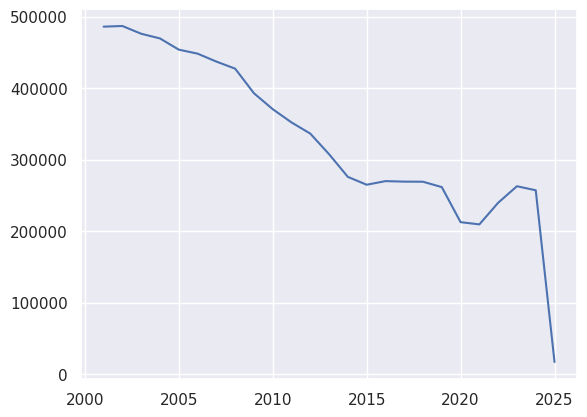

In [12]:
plt.plot(chicago_group.year, chicago_group.arrest)
plt.show()

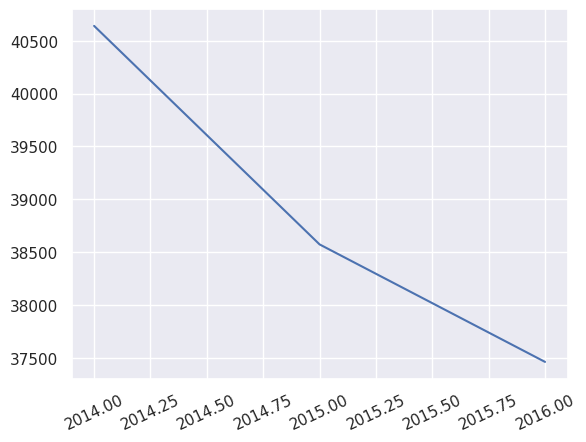

In [13]:
austin_group = austin_df[['year', 'arrest']].groupby(['year']).count().reset_index()
plt.plot(austin_group.year, austin_group.arrest)
plt.xticks(rotation = 25)
plt.show()


In [14]:
austin_df.primary_type.unique()

0                                              Theft
1                    Burglary / 
Breaking & Entering
2                                           Burglary
4                                         Theft: BOV
6                                         Auto Theft
18                                Theft: Shoplifting
20                          Theft: All Other Larceny
24                                              Rape
32                                Aggravated Assault
40                                           Robbery
53                                       Agg Assault
113                            Theft: Pocket Picking
126                                Theft: Auto Parts
400                             Theft: from Building
1576                          Theft: Coin Op Machine
1723    Homicide: Murder & Nonnegligent Manslaughter
1858                                          Murder
2189                          Theft: Purse Snatching
Name: primary_type, dtype: string

In [15]:
new_primary_types = {'Theft':'Theft', 'Burglary / Breaking & Entering':'Burglary', 'Theft: BOV':'Theft','Auto Theft':'Auto Theft','Theft: Shoplifting':'Theft', 'Theft: All Other Larceny':'Theft', 'Rape':'Rape','Aggravated Assault':'Assault', 'Robbery':'Robbery','Agg Assault':'Assault','Theft: Pocket Picking':'Theft','Theft: Auto Parts':'Auto Theft','Theft: from Building':'Theft','Theft: Coin Op Machine':'Theft','Homicide: Murder & Nonnegligent Manslaughter':'Murder','Murder':'Murder','Theft: Purse Snatching':'Theft'}
austin_df['primary_type'] = austin_df.primary_type.map(new_primary_types)

/var/tmp/ipykernel_5883/743437812.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=austin_type_group.primary_type, y=austin_type_group.arrest, palette="deep")


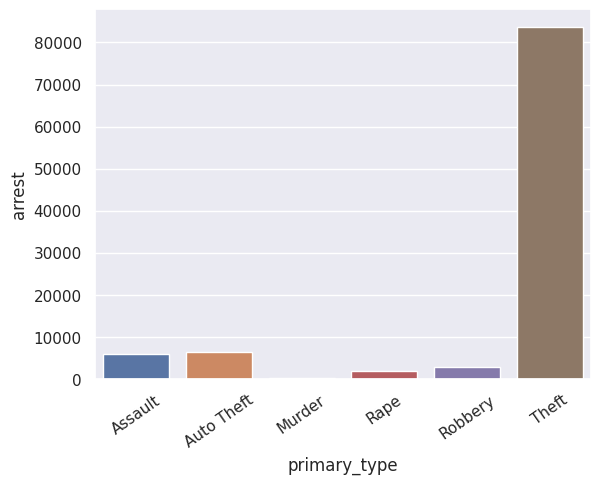

In [16]:
austin_type_group = austin_df[['primary_type', 'arrest']].groupby(['primary_type']).count().reset_index()
sns.barplot(x=austin_type_group.primary_type, y=austin_type_group.arrest, palette="deep")
plt.xticks(rotation = 35)
plt.show()

In [17]:
chicago_df.primary_type.unique()

0                             NARCOTICS
1                         OTHER OFFENSE
2                                 THEFT
4                               BATTERY
6                               ASSAULT
7                   MOTOR VEHICLE THEFT
11                              ROBBERY
12                      CRIMINAL DAMAGE
13              CRIMINAL SEXUAL ASSAULT
16                    CRIMINAL TRESPASS
23                    WEAPONS VIOLATION
25                             BURGLARY
29                   DECEPTIVE PRACTICE
65           OFFENSE INVOLVING CHILDREN
88                                ARSON
102                        PROSTITUTION
177              PUBLIC PEACE VIOLATION
236                 CRIM SEXUAL ASSAULT
299                            STALKING
332                            GAMBLING
384                LIQUOR LAW VIOLATION
399                         SEX OFFENSE
431    INTERFERENCE WITH PUBLIC OFFICER
443                            HOMICIDE
522                          KIDNAPPING


/var/tmp/ipykernel_5883/2366896845.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=chicago_type_group[chicago_type_group['arrest'] > 25000].primary_type, y=chicago_type_group[chicago_type_group['arrest'] > 25000].arrest, palette="deep")


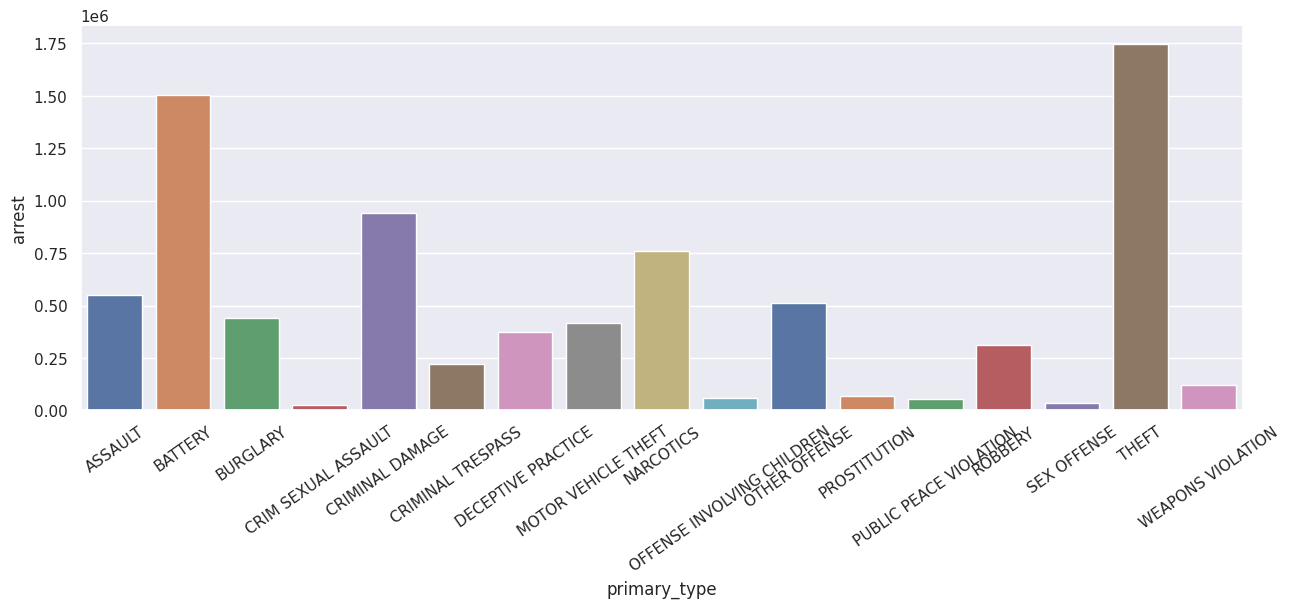

In [19]:
chicago_type_group = chicago_df[['primary_type', 'arrest']].groupby(['primary_type']).count().reset_index()
plt.figure(figsize=(15,5))
sns.barplot(x=chicago_type_group[chicago_type_group['arrest'] > 25000].primary_type, y=chicago_type_group[chicago_type_group['arrest'] > 25000].arrest, palette="deep")

plt.xticks(rotation = 35)
plt.show()

In [20]:
chicago[chicago.primary_type == 'HOMICIDE'].head(20)

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
443,26359,JE404225,2021-10-09 20:06:00+00:00,028XX S KILDARE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,22,30,01A,1148187.0,1884715.0,2021,2022-09-01 15:42:17+00:00,41.839601,-87.731718,"(41.839601232, -87.731718281)"
453,21845,HY243592,2015-05-01 23:30:00+00:00,079XX S ABERDEEN ST,0110,HOMICIDE,FIRST DEGREE MURDER,YARD,False,False,...,17,71,01A,1170363.0,1852094.0,2015,2022-09-19 15:41:05+00:00,41.74963,-87.651292,"(41.749630493, -87.651291874)"
544,26144,JE313919,2021-07-25 18:36:00+00:00,097XX S AVENUE L,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,10,52,01A,1201792.0,1841183.0,2021,2022-09-01 15:42:17+00:00,41.718949,-87.536495,"(41.718948578, -87.536495302)"
1034,28005,JH173204,2024-03-02 20:32:00+00:00,005XX W ROOSEVELT RD,0110,HOMICIDE,FIRST DEGREE MURDER,PARKING LOT,True,False,...,28,28,01A,1173077.0,1894978.0,2024,2024-04-23 15:40:49+00:00,41.867249,-87.640079,"(41.86724898, -87.640079073)"
1290,25663,JD454034,2020-12-09 12:10:00+00:00,082XX S INDIANA AVE,0110,HOMICIDE,FIRST DEGREE MURDER,APARTMENT,True,False,...,6,44,01A,1179023.0,1850507.0,2020,2022-09-19 15:41:05+00:00,41.745083,-87.619606,"(41.745082823, -87.619606449)"
1341,25289,JD292249,2020-07-10 06:06:00+00:00,054XX S TALMAN AVE,0110,HOMICIDE,FIRST DEGREE MURDER,HOUSE,True,False,...,14,63,01A,1159631.0,1868448.0,2020,2022-09-19 15:41:05+00:00,41.794735,-87.69017,"(41.794734948, -87.690170419)"
2272,27299,JG117362,2023-01-15 17:29:00+00:00,062XX S MICHIGAN AVE,0110,HOMICIDE,FIRST DEGREE MURDER,PARKING LOT,True,True,...,20,40,01A,1178263.0,1863570.0,2023,2023-03-22 15:40:28+00:00,41.780946,-87.621995,"(41.780946398, -87.621995369)"
2551,27319,JG129690,2023-01-26 00:33:00+00:00,101XX S WINSTON AVE,0110,HOMICIDE,FIRST DEGREE MURDER,YARD,True,False,...,34,73,01A,1169236.0,1837717.0,2023,2023-04-18 15:40:28+00:00,41.710202,-87.655836,"(41.710202355, -87.655836342)"
2813,28569,JJ120220,2025-01-19 04:13:00+00:00,074XX S STATE ST,0110,HOMICIDE,FIRST DEGREE MURDER,RESTAURANT,True,False,...,6,69,01A,1177570.0,1855556.0,2025,2025-01-27 15:41:27+00:00,41.758971,-87.624778,"(41.758970818, -87.624778076)"
2904,21482,HX352058,2014-07-19 20:21:00+00:00,009XX N MAYFIELD AVE,0110,HOMICIDE,FIRST DEGREE MURDER,AUTO,True,False,...,29,25,01A,1136970.0,1905637.0,2014,2022-09-19 15:41:05+00:00,41.897222,-87.772379,"(41.89722235, -87.772378689)"


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [22]:
chicago_group = chicago_df[['year', 'primary_type','arrest']].groupby(['year','primary_type']).count().reset_index()

In [23]:
X = chicago_group.drop(columns = ['arrest'])
#selecting target
Y = chicago_group['arrest']
#making sure all features are numerical
X.info()

<class 'bigframes.dataframe.DataFrame'>


Index: 781 entries, 0 to 780
Data columns (total 2 columns):


/opt/conda/lib/python3.10/site-packages/bigframes/core/blocks.py:125: NullIndexPreviewWarning: Creating object with Null Index. Null Index is a preview feature.
  warnings.warn(


  #  Column        Non-Null Count    Dtype
---  ------------  ----------------  -------
  0  year          781 non-null      Int64
  1  primary_type  781 non-null      string
dtypes: Int64(1), string(1)


memory usage: 18744 bytes


In [24]:
ptypes_ohe = pd.get_dummies(X.primary_type, drop_first=True)
X = pd.DataFrame(X)
ptypes_ohe = pd.DataFrame(ptypes_ohe)
X = X.join(ptypes_ohe)

In [25]:
X = X.rename(columns = {0:'Year'})
X = X.drop(columns = 1)
X['Year'] = X['Year'].apply(pd.to_numeric)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               781 non-null    int64  
 1   ASSAULT                            781 non-null    boolean
 2   BATTERY                            781 non-null    boolean
 3   BURGLARY                           781 non-null    boolean
 4   CONCEALED CARRY LICENSE VIOLATION  781 non-null    boolean
 5   CRIM SEXUAL ASSAULT                781 non-null    boolean
 6   CRIMINAL DAMAGE                    781 non-null    boolean
 7   CRIMINAL SEXUAL ASSAULT            781 non-null    boolean
 8   CRIMINAL TRESPASS                  781 non-null    boolean
 9   DECEPTIVE PRACTICE                 781 non-null    boolean
 10  DOMESTIC VIOLENCE                  781 non-null    boolean
 11  GAMBLING                           781 non-null    boolean

In [26]:
Y = pd.Series(Y)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, random_state=6)

In [28]:
LR_model = LinearRegression()
LR_model.fit(x_train, y_train)
LR_model_pred_train = LR_model.predict(x_train)
LR_model_train_score = np.sqrt(np.mean((LR_model_pred_train - y_train)**2))
print("DT Mean Training Error: ", LR_model_train_score)


LR_model_pred_test = LR_model.predict(x_test)
LR_model_test_score = np.sqrt(np.mean((LR_model_pred_test - y_test)**2))
print("DT Mean Testing Error: ", LR_model_test_score)

print("Model train score: ", LR_model.score(x_train, y_train))
print("Model test score: ", LR_model.score(x_test, y_test))

DT Mean Training Error:  6478.949316668735
DT Mean Testing Error:  228218292343214.56
Model train score:  0.8722367668599449
Model test score:  -1.1291313668393014e+20
